<a href="https://colab.research.google.com/github/eliasboughosn/Spark-ML/blob/main/BOUGHOSN_Bostondf_Spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version
!pip install pyspark

update-alternatives: using /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java to provide /usr/bin/java (java) in manual mode
openjdk version "1.8.0_275"
OpenJDK Runtime Environment (build 1.8.0_275-8u275-b01-0ubuntu1~18.04-b01)
OpenJDK 64-Bit Server VM (build 25.275-b01, mixed mode)
     |████████████████████████████████| 204.2MB 61kB/s 
     |████████████████████████████████| 204kB 38.2MB/s 
  Created wheel for pyspark: filename=pyspark-3.0.1-py2.py3-none-any.whl size=204612242 sha256=084d9b7de1973148554149b817a3976c4715696e71831c189edd49a6beebb933
  Stored in directory: /root/.cache/pip/wheels/5e/bd/07/031766ca628adec8435bb40f0bd83bb676ce65ff4007f8e73f
Successfully built pyspark


Let's load the data.


In [ ]:
from google.colab import files
files.upload()  # upload 'boston.csv'

In [ ]:
!ls

boston.csv  sample_data


You should have now `boston.csv` in your folder.

## ... or continue from here if you run locally on your machine

## Housing prices in Boston

The goal is to predict the housing prices in the Boston area.

The data is as follows:
  * `crim` — per capita crime rate by town.
  * `zn` — proportion of residential land zoned for lots over 25,000 sq.ft.
  * `indus` — proportion of non-retail business acres per town.
  * `chas` — Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).
  * `nox` — nitrogen oxides concentration (parts per 10 million).
  * `rm` — average number of rooms per dwelling.
  * `age` — proportion of owner-occupied units built prior to 1940.
  * `dis` — weighted mean of distances to five Boston employment centres.
  * `rad` — index of accessibility to radial highways.
  * `tax` — full-value property-tax rate per $10,000.
  * `ptratio` — pupil-teacher ratio by town.
  * `black` — 1000(Bk — 0.63)<sup>2</sup> where Bk is the proportion of blacks by town.
  * `lstat` — lower status of the population (percent).
  * `medv` — median value of owner-occupied homes in \$1000s. **This is the target variable.**

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType

## 0 - Create a spark session named 'houses'

In [ ]:
spark = SparkSession.builder.appName('houses').getOrCreate() #creating a spark session

## 1 - Load the `boston.csv` file into the session
Use proper values for `inferSchema` and `header`, depending on the file itself...

**CALL IT `bostondf`** Otherwise some code may not work later

In [ ]:
bostondf = spark.read.csv('boston.csv', header = True, inferSchema = True) #reading the csv file with names of the columns

## 2 - Print the dataframe schema

In [ ]:
bostondf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- crim: double (nullable = true)
 |-- zn: double (nullable = true)
 |-- indus: double (nullable = true)
 |-- chas: integer (nullable = true)
 |-- nox: double (nullable = true)
 |-- rm: double (nullable = true)
 |-- age: double (nullable = true)
 |-- dis: double (nullable = true)
 |-- rad: integer (nullable = true)
 |-- tax: integer (nullable = true)
 |-- ptratio: double (nullable = true)
 |-- black: double (nullable = true)
 |-- lstat: double (nullable = true)
 |-- medv: double (nullable = true)



In [ ]:
## 3 - Show the first 3 rows of the dataframe

In [ ]:
bostondf.show(3)

+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|_c0|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio| black|lstat|medv|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|  1|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|  2|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|  3|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
+---+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 3 rows



we drop _c0 because it represents the index of rows only

In [ ]:
bostondf = bostondf.drop('_c0')

Dropping na values

In [ ]:
bostondf = bostondf.dropna(how='any')

## 4 - Output basic stats on the dataset.

*hint*: for readability purposes you can `transpose` a description dataframe.


In [ ]:
import pandas as pd
pd.DataFrame(bostondf.take(5), columns=bostondf.columns).transpose() #using pandas to transpose the dataframe for better readability

,0,1,2,3,4
crim,0.00632,0.02731,0.02729,0.03237,0.06905
zn,18.00000,0.00000,0.00000,0.00000,0.00000
indus,2.31000,7.07000,7.07000,2.18000,2.18000
chas,0.00000,0.00000,0.00000,0.00000,0.00000
nox,0.53800,0.46900,0.46900,0.45800,0.45800
rm,6.57500,6.42100,7.18500,6.99800,7.14700
age,65.20000,78.90000,61.10000,45.80000,54.20000
dis,4.09000,4.96710,4.96710,6.06220,6.06220
rad,1.00000,2.00000,2.00000,3.00000,3.00000
tax,296.00000,242.00000,242.00000,222.00000,222.00000


In [ ]:
bostondf.toPandas().describe().transpose() #summary of our dataframe

,count,mean,std,min,25%,50%,75%,max
crim,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
zn,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
indus,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
chas,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
nox,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
rm,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
age,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
dis,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
rad,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
tax,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


## 5 - Scatter Matrix (use pandas)

Scatter matrix is a great way to roughly determine if we have a linear correlation between multiple independent variables. `pandas` does it for us.


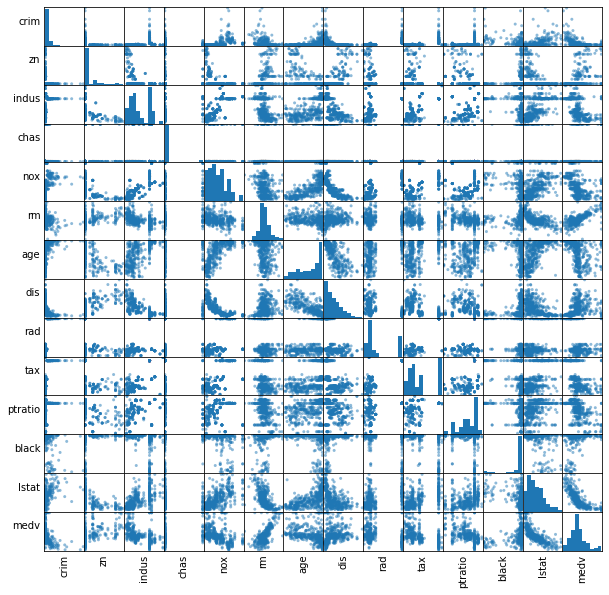

In [ ]:
# DON"T CHANGE THIS. JUST RUN IT
import pandas as pd

numeric_features = [t[0] for t in bostondf.dtypes if t[1] == 'int' or t[1] == 'double']
sampled_data = bostondf.select(numeric_features).sample(False, 0.8).toPandas()
axs = pd.plotting.scatter_matrix(sampled_data, figsize=(10, 10))
n = len(sampled_data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [ ]:
pandasDf= bostondf.toPandas() #we make a pandas dataframe copy so that we can take a better look at the correlation between the features and the target var

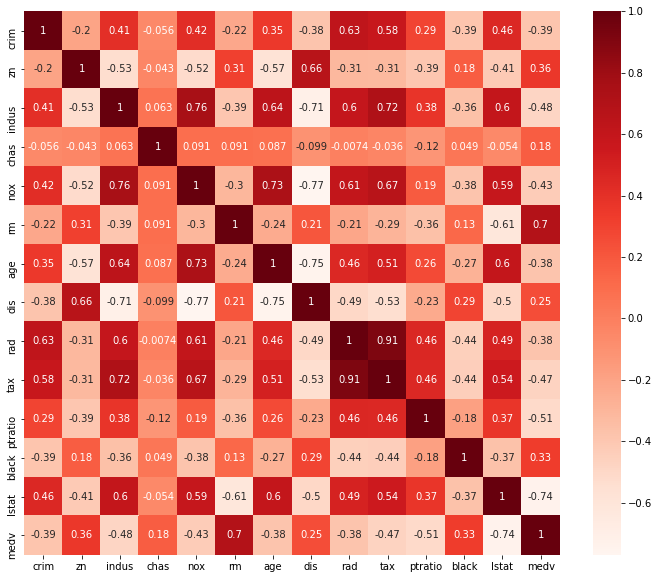

In [ ]:
#Using Pearson Correlation
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,10))
cor = pandasDf.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()


## 6 - Comment on the scatterplot

from both scatter plots, we notice that:

*   For a weak correlation , the points have no direction, the shape is almost 
round, and a line does not fit to the points on the graph. Example: correlation of medv and _c0
*   For a strong correlation, the observations group closer
together in a linear shape. Example: correlation of rm and medv

The line is difficult to detect when the relationship is weak (e.g., r = -0.3), but becomes more clear as relationships become stronger (e.g., r = -0.99).

We also notice that positively correlated variables have an ascending line shape of points on the graph, whereas negatively correlated variables have a descending line shape of points on the graph.
The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, the median value tends to go up when the number of rooms goes up. When the coefficient is close to –1, it means that there is a strong negative correlation; the median value tends to go down when the percentage of the lower status of the population goes up. Finally, coefficients close to zero mean that there is no linear correlation.



## 7 - Compute all correlations with the target variable (`medv`)

*hint*: look at the `stat` attribute of the dataframe

In [ ]:
#if we want to use the spark dataframe we use this code
#we have to use a for loop because in spark u can only compare two variables at a time
{i:bostondf.stat.corr("medv",i) for i in bostondf.columns[:-1]}

{'age': -0.3769545650045961,
 'black': 0.3334608196570661,
 'chas': 0.1752601771902987,
 'crim': -0.38830460858681154,
 'dis': 0.249928734085904,
 'indus': -0.4837251600283728,
 'lstat': -0.7376627261740145,
 'nox': -0.4273207723732821,
 'ptratio': -0.5077866855375622,
 'rad': -0.38162623063977735,
 'rm': 0.6953599470715401,
 'tax': -0.46853593356776674,
 'zn': 0.3604453424505433}

In [ ]:
# if we want to use pandas dataframe we use this code
print(pandasDf.corr()["medv"].sort_values(ascending=False))

medv       1.000000
rm         0.695360
zn         0.360445
black      0.333461
dis        0.249929
chas       0.175260
age       -0.376955
rad       -0.381626
crim      -0.388305
nox       -0.427321
tax       -0.468536
indus     -0.483725
ptratio   -0.507787
lstat     -0.737663
Name: medv, dtype: float64


## 8 - Data preparation

We keep all the variables, for now. **WHY?**

To prepare the data we need features and labels.
Being that data is numerical, we do not have to perform any encoding. Just build the `Vector`.

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline


#we can  use this code but without a pipeline
'''input_columns = bostondf.columns[:-1]
features = VectorAssembler(inputCols=input_columns, outputCol='features')
v_df = features.transform(bostondf)
v_df = v_df.select(['features', 'medv'])
v_df.show(3)'''


stages = []
input_columns = bostondf.columns[:-1] #choosing all columns as features except our target variable
#extracting our features and outputing a column named features.   Note that VectorAssembler is a transformer that combines a given list of columns into a single vector column.
features = VectorAssembler(inputCols=input_columns, outputCol='features') 
stages += [features]# creating stages variable in case we wanted to add another stage other than vectorassembler
pipeline = Pipeline(stages=stages) #here we summed the stages we did in the "stages" variable and defined a pipeline that the data will go through.
v_df = pipeline.fit(bostondf).transform(bostondf) #here the data is fitted to the pipline and transformed.
v_df = v_df.select(['features', 'medv'])#choosing the columns we need
v_df.show(3) #showing first 3 rows of the dataframe



+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
+--------------------+----+
only showing top 3 rows



Let's split the dataset into training and testing sets with a 70:30 ratio

In [ ]:
# DONT CHANGE THIS, Just RUN IT.
splits = v_df.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

## 9 - Linear regression

See the [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#module-pyspark.ml.regression).

Build a linear regression model to fit the data.
  * feature column: `features`
  * label column: `medv`
  * maxIter: 10
  * regParam: 0.3
  * elasticNetParam: 0.8  <- optional

Fit the model and print `coefficients` and `intercept`

In [ ]:
from pyspark.ml.regression import LinearRegression
#building a linear regression model that takes features and predicts the medv variable
lr = LinearRegression(featuresCol='features', labelCol='medv', maxIter=10, regParam=0.3, elasticNetParam=0.8) 
lr_model = lr.fit(train_df) #fitting our model to the training data
print("coefficients: " + str(lr_model.coefficients)) #printing coefficients
print("intercept: " + str(lr_model.intercept))#printing intercept

coefficients: [-0.032216014100895814,0.020910106491995453,0.0,1.9423943657011322,-10.402681490098072,4.404423507419415,0.0,-0.8512990490631689,0.0,-0.000737975929018305,-0.7520647196139266,0.004986082565760614,-0.5175839706578964]
intercept: 22.788391489805374


## 10 - Summary and RMSE

Print the summary of the model, the `RMSE` and the `r2` errors

In [ ]:
trainingSummary = lr_model.summary
print("trainingSummary",trainingSummary) #printing training summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)#printing RMSE error
print("r2: %f" % trainingSummary.r2)#printing r2 error

trainingSummary <pyspark.ml.regression.LinearRegressionTrainingSummary object at 0x7ff53c5f6240>
RMSE: 5.052246
r2: 0.717966


RMSE measures the differences between predicted values by the model and the actual values. However, RMSE alone is meaningless until we compare with the actual `medv` value, such as mean, min and max.

In [ ]:
train_df.describe().show() #showing summary of the medv variable

+-------+------------------+
|summary|              medv|
+-------+------------------+
|  count|               369|
|   mean|22.783468834688353|
| stddev| 9.526280748067935|
|    min|               5.0|
|    max|              50.0|
+-------+------------------+



What can you infer from this results? Is it good or is it bad?




*   R squared at 0.71 indicates that in our model, approximate 71% of the variability in "medv" can be explained using the model which is a relatively good percentage.
*    RMSE alone is meaningless until we compare with the actual "medv" value, such as mean, min and max. After such comparison, the RMSE can be interpreted as the sstandard deviation of the error(residuals) therefore our RMSE looks pretty good.



## 11 - Predictions

Make preditions and evaluate the model (e.g., with `RMSE`). We will use a `RegressionEvaluator` for this.

In [ ]:
lr_predictions = lr_model.transform(test_df) #evaluating the model on the test data 
lr_predictions.select("prediction","medv","features").show(5) #showing top 5 rows of prediction vs actual values of "medv"

+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|30.857676507180862|35.4|[0.01311,90.0,1.2...|
|31.906571068172028|31.6|[0.01432,100.0,1....|
|31.346598554670727|29.1|[0.01439,60.0,2.9...|
|42.289419753868046|50.0|[0.01501,90.0,1.2...|
|26.379054234025688|30.1|[0.01709,90.0,2.0...|
+------------------+----+--------------------+
only showing top 5 rows



In [ ]:
# DON'T TOUCH THIS. JUST RUN
from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="medv", metricName="r2")
print("R Squared (R2) on test data = %g" % lr_evaluator.evaluate(lr_predictions))

R Squared (R2) on test data = 0.721687


In [ ]:
from pyspark.mllib.evaluation import RegressionMetrics
 
test_result = lr_model.evaluate(test_df) #evaluating the model on the test dataset
print("Root Mean Squared Error (RMSE) on test data = %g" % test_result.rootMeanSquaredError)

Root Mean Squared Error (RMSE) on test data = 4.33128


In [ ]:
print("numIterations: %d" % trainingSummary.totalIterations) #printing number of iterations
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory)) #printing objective history

trainingSummary.residuals.show()

numIterations: 11
objectiveHistory: [0.49999999999999956, 0.43340532261619885, 0.2351817576457489, 0.21188157155898163, 0.18391354595139503, 0.1810476494066035, 0.1804343077707198, 0.1793181969596925, 0.17835970666344286, 0.17751255759119022, 0.1774372750732102]
+-------------------+
|          residuals|
+-------------------+
| -6.721575521785276|
| 0.5050481288432493|
| -6.072905954904595|
| 0.6170041768798455|
| 1.0028389997190246|
| 10.642295797905973|
|-3.4128583454012116|
|  7.813452174607377|
| -3.379394839507775|
| 7.0909177930701475|
|  9.290146731567624|
|-1.6428397408310254|
|  4.874776857305704|
|-0.8563130017830503|
| -9.566937977097382|
| -4.368351881049296|
| 3.0665726812625103|
| -4.043886380729575|
| 0.6594398027882988|
| 0.5289424148293485|
+-------------------+
only showing top 20 rows



We can use the model to make some predictions on the testing set.

In [ ]:
predictions = lr_model.transform(test_df)
predictions.select("prediction", "medv", "features").show()


+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
|30.857676507180862|35.4|[0.01311,90.0,1.2...|
|31.906571068172028|31.6|[0.01432,100.0,1....|
|31.346598554670727|29.1|[0.01439,60.0,2.9...|
|42.289419753868046|50.0|[0.01501,90.0,1.2...|
|26.379054234025688|30.1|[0.01709,90.0,2.0...|
| 32.02336405233423|32.9|[0.01778,95.0,1.4...|
|21.302920693268526|20.1|[0.01965,80.0,1.7...|
| 27.65630751808562|25.0|[0.02875,28.0,15....|
|26.223761237463087|28.7|[0.02985,0.0,2.18...|
| 19.92972571458683|17.5|[0.03113,0.0,4.39...|
| 20.37587690269342|19.5|[0.03427,0.0,5.19...|
| 24.69293843889377|19.4|[0.03466,35.0,6.0...|
|31.682452380846698|28.5|[0.03502,80.0,4.9...|
|25.007033607772012|22.9|[0.03551,25.0,4.8...|
|29.600157506462207|23.5|[0.03584,80.0,3.3...|
|26.372704478061163|23.2|[0.03871,52.5,5.3...|
| 36.27853787408605|33.3|[0.04011,80.0,1.5...|
| 28.65357900964983|28.0|[0.04113,25.0,4.8...|
| 27.65743114

## 12 - Decision tree regression and Gradient-boosted tree regression

Try to do the same thing with these 2 regressors.
Which will result better? 

See the [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor).

In [ ]:
from pyspark.ml.regression import DecisionTreeRegressor
#building a decision tree regression model
#we set featuescol to features and labelcol to medv which is the variable we want to predict
dt = DecisionTreeRegressor(featuresCol='features', labelCol='medv',  maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0)
dt_model = dt.fit(train_df) #fitting our training data to the model
dt_predictions = dt_model.transform(test_df)
dt_predictions.select('prediction', 'medv', 'features').show(5) #showing 5 rows of predictions vs actual values of target variable


+-----------------+----+--------------------+
|       prediction|medv|            features|
+-----------------+----+--------------------+
|35.35555555555556|35.4|[0.01311,90.0,1.2...|
|          31.3375|31.6|[0.01432,100.0,1....|
|          31.3375|29.1|[0.01439,60.0,2.9...|
|            42.55|50.0|[0.01501,90.0,1.2...|
|          31.3375|30.1|[0.01709,90.0,2.0...|
+-----------------+----+--------------------+
only showing top 5 rows



Evaluating our model's performance on test data

In [ ]:
dt_evaluator = RegressionEvaluator(labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = dt_evaluator.evaluate(dt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.79813


In [ ]:
dt_model.featureImportances

SparseVector(13, {0: 0.0427, 1: 0.0003, 4: 0.012, 5: 0.6309, 7: 0.0636, 9: 0.0037, 10: 0.0278, 11: 0.0122, 12: 0.2068})

In [ ]:
bostondf.take(1)

[Row(crim=0.00632, zn=18.0, indus=2.31, chas=0, nox=0.538, rm=6.575, age=65.2, dis=4.09, rad=1, tax=296, ptratio=15.3, black=396.9, lstat=4.98, medv=24.0)]

Apparently, the lower status of the population (percent) "lstat" is the most important feature to predict medv — median value of owner-occupied homes in $1000s in our data.

### Gradient-boosted tree regression

See the [docs](https://spark.apache.org/docs/3.0.0/api/python/pyspark.ml.html#pyspark.ml.regression.GBTRegressor).

In [ ]:
from pyspark.ml.regression import GBTRegressor
#building our gradient boost tree regression
#we set featuescol to features and labelcol to medv which is the variable we want to predict
gbt = GBTRegressor(featuresCol='features', labelCol='medv', maxIter=10)
gbt_model = gbt.fit(train_df)  #fitting our training data to the model
gbt_predictions = gbt_model.transform(test_df)

gbt_predictions.select('prediction', 'medv', 'features').show(5) #showing 5 rows of predictions vs actual values of target variable


+------------------+----+--------------------+
|        prediction|medv|            features|
+------------------+----+--------------------+
| 35.16867943081128|35.4|[0.01311,90.0,1.2...|
|31.233417870783683|31.6|[0.01432,100.0,1....|
|31.270895561987402|29.1|[0.01439,60.0,2.9...|
| 44.35924416452444|50.0|[0.01501,90.0,1.2...|
| 33.02534461088971|30.1|[0.01709,90.0,2.0...|
+------------------+----+--------------------+
only showing top 5 rows



Evaluating our model's performance on test data

In [ ]:
gbt_evaluator = RegressionEvaluator(
    labelCol="medv", predictionCol="prediction", metricName="rmse")
rmse = gbt_evaluator.evaluate(gbt_predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 3.69317


In conclusion, gradient boost tree performed better on our data. Since RMSE is influenced by units of the response variable ,  there is not a good or bad value, we can only use it to compare. and we choose the model with lowest RMSE. In this case, gradient boost tree.